<a href="https://colab.research.google.com/github/MatteoFasulo/Sexism-detection/blob/assignment2/Assignment_2_refactoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2


**Keywords**: Sexism Detection, Multi-class Classification, LLMs, Prompting


## Group

* Luca Babboni - luca.babboni2@studio.unibo.it
* Matteo Fasulo - matteo.fasulo@studio.unibo.it
* Maksim Omelchenko - maksim.omelchenko@studio.unibo.it
* Luca Tedeschini - luca.tedeschini3@studio.unibo.it



## Description

This notebook addresses [EDOS Task A](https://github.com/rewire-online/edos) on sexism detection.


## Problem definition

Given an input text sentence, the task is to label the sentence as sexist or not sexist (binary classification).

### Examples:

**Text**: *``Schedule a date with her, then don't show up. Then text her "GOTCHA B___H".''*

**Label**: Sexist

**Text**: *``That’s completely ridiculous a woman flashing her boobs is not sexual assault in the slightest.''*

**Label**: Not sexist



## Approach

We will tackle the binary classification task with LLMs.

In particular, we'll consider zero-/few-shot prompting approaches to assess the capability of some popular open-source LLMs on this task.

## Preliminaries

We are going to download LLMs from [Huggingface](https://huggingface.co/).

Many of these open-source LLMs require you to accept their "Community License Agreement" to download them.

In summary:

- If not already, create an account of Huggingface (~2 mins)
- Check a LLM model card page (e.g., [Mistral v3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3)) and accept its "Community License Agreement".
- Go to your account -> Settings -> Access Tokens -> Create new token -> "Repositories permissions" -> add the LLM model card you want to use.
- Save the token (we'll need it later)

### Libraries
In order to excecute the code we are gonna install and import the necessary libraries.
First of all we are gonna install the last version of bitsandbytes in order to been able to use the quantization.

In [1]:
%%capture
%pip install -U bitsandbytes

Then we need to reload the notebook kernel

In [ ]:
import os
os.kill(os.getpid(), 9)

Finally we are able to import the required libraries

In [2]:
import pandas as pd
from pathlib import Path
import requests
import os
import random
from copy import deepcopy
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

### Huggingface Login

Once we have created an account and an access token, we need to login to Huggingface via code.

- Type your token and press Enter
- You can say No to Github linking

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `Deleteme` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `Deleteme`


In [ ]:
from kaggle_secrets import UserSecretsClient
secret_label = "hf_key"
secret_value = UserSecretsClient().get_secret(secret_label)

In [ ]:
!huggingface-cli login --token {secret_value}

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


After login, you can download all models associated with your access token in addition to those that are not protected by an access token.

### Data Loading

Since we are only interested in prompting, we do not require a train dataset.

We have preparared a small test set version of EDOS in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material).

Check the ``Assignment 2/data`` folder.
It contains:

- ``a2_test.csv`` → a small test set of 300 samples.
- ``demonstrations.csv`` -> a batch of 1000 samples for few-shot prompting.

Both datasets contain a balanced number of sexist and not sexist samples.


### Instructions

We require you to:

* **Download** the ``A2/data`` folder.
* **Encode** ``a2_test.csv`` into a ``pandas.DataFrame`` object.

In [4]:
def download_corpus(url: str, filename: str) -> None:
    """
    Downloads a text corpus from a given URL and saves it to a specified filename within the data folder if not exist

    Args:
        url (str): The URL from which to download the corpus.
        filename (str): The name of the file to save the downloaded corpus.

    Raises:
        requests.exceptions.HTTPError: If the HTTP request returned an unsuccessful status code.

    Side Effects:
        Creates the data folder if it does not exist.
        Writes the downloaded corpus to the specified file.
    """
    data_folder = Path("./data")
    if not data_folder.exists():
      data_folder.mkdir(parents=True)
      print(f"Created folder {data_folder}.")

    if not (data_folder / filename).exists():
      response = requests.get(url)
      response.raise_for_status()
      with open(data_folder / filename, 'w', encoding='utf-8') as f:
        f.write(response.text)
      print(f"Created file {data_folder / filename}.")
    else:
      print(f"File {data_folder / filename} already exists.")

In [5]:
path_test = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%202/data/a2_test.csv'
path_demonstrations = 'https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%202/data/demonstrations.csv'

In [6]:
download_corpus(path_test, 'a2_test.csv')
download_corpus(path_demonstrations, 'demonstrations.csv')

Created folder data.
Created file data/a2_test.csv.
Created file data/demonstrations.csv.


In [7]:
df = pd.read_csv('./data/a2_test.csv', encoding='utf-8')
df.head()

,rewire_id,text,label_sexist
0,sexism2022_english-17133,The boys must be gaming because there goes the...,not sexist
1,sexism2022_english-14197,Look at those eyes. Either someone unexpectedl...,sexist
2,sexism2022_english-3018,Old man mogs everyone in this sub,not sexist
3,sexism2022_english-5301,"Excellent, I was just looking at another post ...",not sexist
4,sexism2022_english-17796,So you run back to daddy whenever you need hel...,sexist


# Mistral V3 instruct in 8bit
As first model we are gonna analyze the performance of Mistral V3

## Task 1 - Model setup

Once the test data has been loaded, we have to setup the model pipeline for inference.

In particular, we have to:
- Load the model weights from Huggingface
- Quantize the model to fit into a single-GPU limited hardware


In [8]:
def load_model(model_card):
    """
    Loads a pre-trained model and its tokenizer with 8-bit quantization.

    Args:
        model_card (str): The identifier of the pre-trained model to load.

    Returns:
        tuple: A tuple containing the quantized model and the tokenizer.
            - model_8bit (transformers.PreTrainedModel): The quantized model loaded in 8-bit precision.
            - tokenizer (transformers.PreTrainedTokenizer): The tokenizer associated with the model.
    """
    quantization_config = BitsAndBytesConfig(load_in_8bit=True)
    tokenizer = AutoTokenizer.from_pretrained(model_card)
    model_8bit = AutoModelForCausalLM.from_pretrained(model_card, quantization_config=quantization_config)
    model_8bit.eval()
    return model_8bit, tokenizer

In [9]:
model_card = 'mistralai/Mistral-7B-Instruct-v0.3'
model_8bit, tokenizer = load_model(model_card)

device = model_8bit.device
print(f'Model loaded on {device}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Model loaded on cuda:0


## Task 2 - Prompt setup

Prompting requires an input pre-processing phase where we convert each input example into a specific instruction prompt.


### Prompt Template

Use the following prompt template to process input texts.

In [10]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

### Instructions

In order to get Task 2 points, we require you to:

* Write the ``prepare_prompts`` function

In [11]:
def prepare_prompts(texts, prompt_template, tokenizer, device):
  """
    This function format input text samples into instructions prompts.

    Inputs:
      texts: input texts to classify via prompting
      prompt_template: the prompt template provided in this assignment
      tokenizer: the transformers Tokenizer object instance associated with the chosen model card

    Outputs:
      input texts to classify in the form of instruction prompts
  """
  prompts = []
  for text in texts:
    prompt_with_text = deepcopy(prompt_template)
    # add text
    prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)

    prompts.append(tokenizer.apply_chat_template(prompt_with_text, tokenize=True,
                                                 add_generation_prompt=True,
                                                 return_dict=True,
                                                 return_tensors="pt").to(device))

  return prompts

In [12]:
prompts = prepare_prompts(df['text'], prompt, tokenizer, device=device)

print("Prompt example: \n")
print(tokenizer.decode(prompts[0].input_ids[0], skip_special_tokens=True))

Prompt example: 

You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:
        


## Task 3 - Inference

We are now ready to define the inference loop where we prompt the model with each pre-processed sample.

### Instructions

In order to get Task 3 points, we require you to:

* Write a ``generate_responses`` function as the one reported below.
* Write a ``process_response`` function as the one reported below.

In [13]:
def generate_responses(model, prompt_examples):
  """
    This function implements the inference loop for a LLM model.
    Given a set of examples, the model is tasked to generate a response.

    Inputs:
      model: LLM model instance for prompting
      prompt_examples: pre-processed text samples

    Outputs:
      generated responses
  """
  answers = []
  for prompt in tqdm(prompt_examples):
    response = model.generate(**prompt, max_new_tokens=1000, pad_token_id=tokenizer.eos_token_id)
    answers.append(response)
  return answers

In [14]:
def process_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to map the response to a binary label.

    Inputs:
      response: generated response from LLM

    Outputs:
      parsed binary response: return 1 if YES and 0 if NO
  """
  response = tokenizer.decode(response[0])
  if 'YES' in response.split('ANSWER')[-1]:
    return 1
  else:
    return 0

In [15]:
answers = generate_responses(model_8bit, prompts)

100%|██████████| 300/300 [04:11<00:00,  1.19it/s]


In [16]:
raw_answers = [tokenizer.decode(item[0]) for item in answers]
batch_predictions = [process_response(item) for item in answers]

In [24]:
original_labels = [1 if label == 'sexist' else 0 for label in df['label_sexist']]

In [29]:
models_predictions = pd.DataFrame({
    'text': df['text'],
    'original_labels': original_labels,
    'Mistralv3_zero_shot': batch_predictions,
})

In [31]:
models_predictions.head()

,text,original_labels,Mistralv3_zero_shot
0,The boys must be gaming because there goes the...,0,1
1,Look at those eyes. Either someone unexpectedl...,1,1
2,Old man mogs everyone in this sub,0,0
3,"Excellent, I was just looking at another post ...",0,1
4,So you run back to daddy whenever you need hel...,1,1


## Task 4 - Metrics

In order to evaluate selected LLMs, we need to compute performance metrics.

In particular, we are interested in computing **accuracy** since the provided data is balanced with respect to classification classes.

Moreover, we want to compute the ratio of failed responses generated by models.

That is, how frequent the LLM fails to follow instructions and provides incorrect responses that do not address the classification task.

We denote this metric as **fail-ratio**.

In summary, we parse generated responses as follows:
- 1 if the model says YES
- 0 if the model says NO
- 0 if the model does not answer in either way

### Instructions

In order to get Task 4 points, we require you to:

* Write a ``compute_metrics`` function as the one reported below.
* Compute metrics for the two selected LLMs.

In [32]:
def compute_metrics(responses, y_true):
  """
    This function takes predicted and ground-truth labels and compute metrics.
    In particular, this function compute accuracy and fail-ratio metrics.
    This function internally invokes `process_response` to compute metrics.

    Inputs:
      responses: generated LLM responses
      y_true: ground-truth binary labels

    Outputs:
      dictionary containing desired metrics
  """
  y_pred = [process_response(response) for response in responses]
  accuracy = (np.array(y_pred) == np.array(y_true)).mean()
  fail_ratio = (np.array(y_pred) != np.array(y_true)).mean()
  return {'accuracy': accuracy, 'fail_ratio': fail_ratio}

In [43]:
mistal_base_metrics = compute_metrics(answers, original_labels)

In [51]:
for key, value in mistal_base_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.61
fail_ratio: 0.39


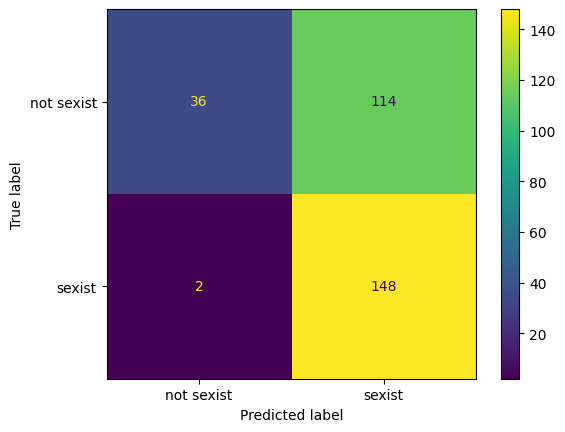

In [54]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

responses = [process_response(response) for response in answers]
confusion_matrix = metrics.confusion_matrix(original_labels, responses)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["not sexist", "sexist"])

cm_display.plot()
plt.show()

## Task 5 - Few-shot Inference

So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response.

We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the prompt template as follows.

In [62]:
prompt_few_shot = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

The new prompt template reports some demonstration examples to instruct the model.

Generally, we provide an equal number of demonstrations per class as shown in the example below.

```
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: **example 1**
        ANSWER: YES
        TEXT: **example 2**
        ANSWER: NO

        TEXT:
        {text}

        ANSWER:
        """
    }
]
```  

## Instructions

In order to get Task 5 points, we require you to:

- Load ``demonstrations.csv`` and encode it into a ``pandas.DataFrame`` object.
- Define a ``build_few_shot_demonstrations`` function as the one reported below.
- Perform few-shot inference as in Task 3.
- Compute metrics as in Task 4.

In [55]:
demonstrations = pd.read_csv('./data/demonstrations.csv')
demonstrations.head()

,rewire_id,text,label_sexist
0,sexism2022_english-10348,I would never have my kid go to a daycare with...,not sexist
1,sexism2022_english-7950,Democrat women are so butt fucking ugly.,sexist
2,sexism2022_english-7742,If you really wanted to twist the knife you’d ...,not sexist
3,sexism2022_english-16170,Those women are pro-rape. They didn’t care abo...,sexist
4,sexism2022_english-9857,Married a bitch... Is it the standard scenario...,sexist


In [56]:
def build_few_shot_demonstrations(demonstrations, num_per_class=2):
  """
    Inputs:
      demonstrations: the pandas.DataFrame object wrapping demonstrations.csv
      num_per_class: number of demonstrations per class

    Outputs:
      a list of textual demonstrations to inject into the prompt template.
  """
  yes_samples = demonstrations[demonstrations['label_sexist'] == 'sexist'].sample(num_per_class)
  no_samples = demonstrations[demonstrations['label_sexist'] == 'not sexist'].sample(num_per_class)

  few_shot_demonstrations = list(pd.concat([yes_samples['text'], no_samples['text']]))

  return few_shot_demonstrations

In [57]:
build_few_shot_demonstrations(demonstrations, num_per_class=2)

["New don't park on me poster finished. This is dedicated to the twat who harassed me with her minivan last week.",
 "It's because they have wombs. Money is only the second most important thing in life. You can end your life with all the money in the world, if you didn't pass on your genes, you lose.",
 "Is she never going to the gym again? You'll definitely see her again man don't beat yourself up",
 "Oh no. I'm sorry and pissed off to hear. Is that where the stabbing of the female motorist happened as well? My son recently had one of his best buddies move to Phili area."]

In [58]:
def prepare_prompts_few_shot(texts, demonstrations, prompt_template, tokenizer, device):
  """
    This function format input text samples into instructions prompts.

    Inputs:
      texts: input texts to classify via prompting
      prompt_template: the prompt template provided in this assignment
      tokenizer: the transformers Tokenizer object instance associated with the chosen model card

    Outputs:
      input texts to classify in the form of instruction prompts
  """
  prompts = []
  for text in texts:
    prompt_with_text = deepcopy(prompt_template)
    demonstration = ''
    for i, d in enumerate(demonstrations):
      if i < len(demonstrations) // 2:
        demonstration += '\tTEXT: ' + d + '\n\tANSWER: YES\n'
      else:
        demonstration += '\tTEXT: ' + d + '\n\tANSWER: NO\n'

    # remove extra \t
    demonstration = demonstration[1:]
    prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{examples}', demonstration)

    prompt_with_text[1]['content'] = prompt_with_text[1]['content'].replace('{text}', text)
    prompts.append(tokenizer.apply_chat_template(prompt_with_text, tokenize=True, add_generation_prompt=True,
              return_dict=True,
              return_tensors="pt").to(device))

  return prompts

### 4-shot leaning

In [63]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=2), prompt_few_shot, tokenizer, device=device)

In [64]:
print(tokenizer.decode(prompts_few_shot[0].input_ids[0]))

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: [USER] I think it's assumed that they're losers. The whole thing is a bunch of misandrist loser women LARPing about being relevant.
	ANSWER: YES
	TEXT: Being raped boosts your status among other women so you get a bunch of women sitting around one upping each other about who had the worst rape. It's one of the biggest red pills.
	ANSWER: YES
	TEXT: Absolutely. it should be something extended to all non violent criminals male and female. The prison systems especially in the US are big business. If the government really wanted to fight the war on drugs it should go for the top echelons.
	ANSWER: NO
	TEXT: Kabballa vitim exposes Jewish sect of ritual devil and ritual practices Mind you Oprah is also a Devil Worshiper that has sold her soul for fame and riches. [URL]
	ANSWER: NO


        TEXT:
        The boys must 

In [66]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [10:33<00:00,  2.11s/it]


In [67]:
mistalv3_4_shot_metrics = compute_metrics(answers, original_labels)

for key, value in mistalv3_4_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.64
fail_ratio: 0.36


In [68]:
batch_predictions = [process_response(item) for item in answers]
models_predictions['mistalv3_4_shot'] = batch_predictions

### 8-shot leaning

In [69]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=4), prompt, tokenizer, device=device)

In [70]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [07:53<00:00,  1.58s/it]


In [73]:
mistalv3_8_shot_metrics = compute_metrics(answers, original_labels)

for key, value in mistalv3_8_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.69
fail_ratio: 0.31


In [74]:
batch_predictions = [process_response(item) for item in answers]
models_predictions['mistalv3_8_shot'] = batch_predictions

12 shot

In [75]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=6), prompt, tokenizer, device=device)

In [76]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [06:41<00:00,  1.34s/it]


In [77]:
mistalv3_12_shot_metrics = compute_metrics(answers, original_labels)

for key, value in mistalv3_12_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.71
fail_ratio: 0.29


In [78]:
batch_predictions = [process_response(item) for item in answers]
models_predictions['mistalv3_12_shot'] = batch_predictions

# Llama 2 8B

## Task 1 - Model setup

In [83]:
del model_8bit
torch.cuda.empty_cache()

In [86]:
import gc

with torch.no_grad():
  torch.cuda.empty_cache()

gc.collect()

0

In [87]:
model_card = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
model_8bit, tokenizer = load_model(model_card)

device = model_8bit.device
print(f'Model loaded on {device}')

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Model loaded on cuda:0


## Task 2 - Prompt setup

In [88]:
prompts = prepare_prompts(df['text'], prompt, tokenizer, device=device)

print("Prompt example: \n")
print(tokenizer.decode(prompts[0].input_ids[0], skip_special_tokens=True))

Prompt example: 

system

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an annotator for sexism detection.user

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        The boys must be gaming because there goes the wifi.

        ANSWER:assistant




## Task 3 - Inference


In [89]:
answers = generate_responses(model_8bit, prompts)

100%|██████████| 300/300 [01:38<00:00,  3.06it/s]


In [90]:
raw_answers = [tokenizer.decode(item[0]) for item in answers]
batch_predictions = [process_response(item) for item in answers]

In [91]:
models_predictions['llama3_zero_shot'] = batch_predictions

## Task 4 - Metrics

In [92]:
llama3_base_metrics = compute_metrics(answers, original_labels)

In [93]:
for key, value in llama3_base_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.68
fail_ratio: 0.32


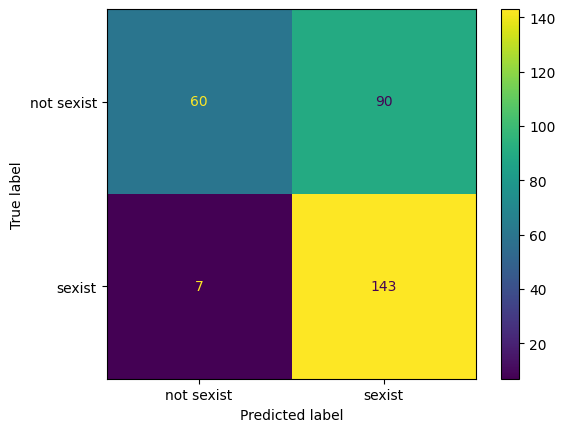

In [94]:
responses = [process_response(response) for response in answers]
confusion_matrix = metrics.confusion_matrix(original_labels, responses)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["not sexist", "sexist"])

cm_display.plot()
plt.show()

## Task 5 - Few-shot Inference

### 4-shot leaning

In [95]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=2), prompt_few_shot, tokenizer, device=device)

In [96]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [02:56<00:00,  1.70it/s]


In [97]:
llama3_4_shot_metrics = compute_metrics(answers, original_labels)

for key, value in llama3_4_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.67
fail_ratio: 0.33


In [98]:
batch_predictions = [process_response(item) for item in answers]
models_predictions['llama3_4_shot'] = batch_predictions

### 8-shot leaning

In [99]:
prompts_few_shot = prepare_prompts_few_shot(df['text'], build_few_shot_demonstrations(demonstrations, num_per_class=4), prompt, tokenizer, device=device)

In [100]:
answers = generate_responses(model_8bit, prompts_few_shot)

100%|██████████| 300/300 [02:36<00:00,  1.92it/s]


In [101]:
llama3_8_shot_metrics = compute_metrics(answers, original_labels)

for key, value in llama3_8_shot_metrics.items():
  print(f'{key}: {value:.2f}')

accuracy: 0.64
fail_ratio: 0.36


In [102]:
batch_predictions = [process_response(item) for item in answers]
models_predictions['llama3_8_shot'] = batch_predictions

In [103]:
df.to_csv('models_predictions.csv')

# [Task 6 - 1.0 points] Error Analysis

We are now interested in evaluating model responses and comparing their performance.

This analysis helps us in understanding

- Classification task performance gap: are the models good at this task?
- Generation quality: which kind of responses do models generate?
- Errors: which kind of mistakes do models do?

### Instructions

In order to get Task 6 points, we require you to:

* Compare classification performance of selected LLMs in a Table.
* Compute confusion matrices for selected LLMs.
* Briefly summarize your observations on generated responses.

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

# FAQ

Please check this frequently asked questions before contacting us.

### Model cards

You can pick any open-source model card you like.

We recommend starting from those reported in this assignment.

### Implementation

Everything can be done via ``transformers`` APIs.

However, you are free to test frameworks, such as [LangChain](https://www.langchain.com/), [LlamaIndex](https://www.llamaindex.ai/) [LitParrot](https://github.com/awesome-software/lit-parrot), provided that you correctly address task instructions.

### Bonus Points

0.5 bonus points are arbitrarily assigned based on significant contributions such as:

- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
- Evaluate A1 dataset and perform comparison

Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

### Prompt Template

Do not change the provided prompt template.

You are only allowed to change it in case of a possible extension.

### Optimizations

Any kind of code optimization (e.g., speedup model inference or reduce computational cost) is more than welcome!

# The End